# Library

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.xception import Xception

# Others
import shutil
import random

# Load dataset

In [4]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/grape/train",
    label_mode="categorical",
    class_names=['Grape Esca (Black_Measles)','Grape Leaf blight (Isariopsis_Leaf_Spot)','grape leaf Healthy','grape leaf black rot'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/grape/valid",
    label_mode="categorical",
    class_names=['Grape Esca (Black_Measles)','Grape Leaf blight (Isariopsis_Leaf_Spot)','grape leaf Healthy','grape leaf black rot'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 7335 files belonging to 4 classes.
==========================Validation Data====================
Found 1825 files belonging to 4 classes.


In [5]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale = 1.0/256.)
test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("Dataset/grape/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("Dataset/grape/valid",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 7335 images belonging to 4 classes.
Found 1825 images belonging to 4 classes.


# List Resource

In [6]:
# Check GPU
!nvidia-smi

Thu May 25 12:05:44 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.79                 Driver Version: 531.79       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 L...  WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   54C    P0               39W /  N/A|   4683MiB /  6144MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Modelling Without Augmentation

## DIY Model 1

In [9]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Grape_DIY_model1_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [10]:
# Define DIY Model
DIY_model = tf.keras.models.Sequential([
    # Convolutional Layers with 32 filters
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),
    # Convolutional Layers with 64 filters
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Convolutional Layers with 128 filters
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
DIY_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DIY_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [11]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DIY_model = DIY_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
367/367 [==============================] - ETA: 0s - loss: 0.5003 - accuracy: 0.8180
Epoch 1: val_accuracy improved from -inf to 0.93425, saving model to Grape_DIY_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Grape_DIY_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DIY_model1_Based_Non_Augmented\assets


367/367 [==============================] - 60s 153ms/step - loss: 0.5003 - accuracy: 0.8180 - val_loss: 0.1764 - val_accuracy: 0.9342 - lr: 0.0010
Epoch 2/100
367/367 [==============================] - ETA: 0s - loss: 0.1551 - accuracy: 0.9448
Epoch 2: val_accuracy improved from 0.93425 to 0.94521, saving model to Grape_DIY_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Grape_DIY_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DIY_model1_Based_Non_Augmented\assets


367/367 [==============================] - 17s 45ms/step - loss: 0.1551 - accuracy: 0.9448 - val_loss: 0.1516 - val_accuracy: 0.9452 - lr: 0.0010
Epoch 3/100
366/367 [============================>.] - ETA: 0s - loss: 0.1152 - accuracy: 0.9605
Epoch 3: val_accuracy did not improve from 0.94521
367/367 [==============================] - 14s 39ms/step - loss: 0.1149 - accuracy: 0.9606 - val_loss: 0.2830 - val_accuracy: 0.9112 - lr: 0.0010
Epoch 4/100
367/367 [==============================] - ETA: 0s - loss: 0.0906 - accuracy: 0.9689
Epoch 4: val_accuracy improved from 0.94521 to 0.96384, saving model to Grape_DIY_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Grape_DIY_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DIY_model1_Based_Non_Augmented\assets


367/367 [==============================] - 17s 46ms/step - loss: 0.0906 - accuracy: 0.9689 - val_loss: 0.1300 - val_accuracy: 0.9638 - lr: 0.0010
Epoch 5/100
366/367 [============================>.] - ETA: 0s - loss: 0.0471 - accuracy: 0.9835
Epoch 5: val_accuracy did not improve from 0.96384
367/367 [==============================] - 15s 40ms/step - loss: 0.0470 - accuracy: 0.9835 - val_loss: 0.2177 - val_accuracy: 0.9244 - lr: 0.0010
Epoch 6/100
366/367 [============================>.] - ETA: 0s - loss: 0.0307 - accuracy: 0.9889
Epoch 6: val_accuracy improved from 0.96384 to 0.97644, saving model to Grape_DIY_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Grape_DIY_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DIY_model1_Based_Non_Augmented\assets


367/367 [==============================] - 17s 47ms/step - loss: 0.0307 - accuracy: 0.9888 - val_loss: 0.0806 - val_accuracy: 0.9764 - lr: 0.0010
Epoch 7/100
367/367 [==============================] - ETA: 0s - loss: 0.0263 - accuracy: 0.9918
Epoch 7: val_accuracy improved from 0.97644 to 0.97973, saving model to Grape_DIY_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Grape_DIY_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DIY_model1_Based_Non_Augmented\assets


367/367 [==============================] - 18s 50ms/step - loss: 0.0263 - accuracy: 0.9918 - val_loss: 0.1027 - val_accuracy: 0.9797 - lr: 0.0010
Epoch 8/100
366/367 [============================>.] - ETA: 0s - loss: 0.0101 - accuracy: 0.9969
Epoch 8: val_accuracy did not improve from 0.97973
367/367 [==============================] - 15s 42ms/step - loss: 0.0101 - accuracy: 0.9969 - val_loss: 0.1342 - val_accuracy: 0.9732 - lr: 0.0010
Epoch 9/100
367/367 [==============================] - ETA: 0s - loss: 0.0361 - accuracy: 0.9892
Epoch 9: val_accuracy did not improve from 0.97973
367/367 [==============================] - 15s 41ms/step - loss: 0.0361 - accuracy: 0.9892 - val_loss: 0.1192 - val_accuracy: 0.9704 - lr: 0.0010
Epoch 10/100
366/367 [============================>.] - ETA: 0s - loss: 0.0360 - accuracy: 0.9889
Epoch 10: val_accuracy did not improve from 0.97973
367/367 [==============================] - 15s 41ms/step - loss: 0.0360 - accuracy: 0.9888 - val_loss: 0.1608 - val_

INFO:tensorflow:Assets written to: Grape_DIY_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DIY_model1_Based_Non_Augmented\assets


367/367 [==============================] - 18s 50ms/step - loss: 0.0027 - accuracy: 0.9996 - val_loss: 0.0840 - val_accuracy: 0.9825 - lr: 1.0000e-04
Epoch 13/100
366/367 [============================>.] - ETA: 0s - loss: 6.3286e-04 - accuracy: 1.0000
Epoch 13: val_accuracy improved from 0.98247 to 0.98575, saving model to Grape_DIY_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Grape_DIY_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DIY_model1_Based_Non_Augmented\assets


367/367 [==============================] - 19s 51ms/step - loss: 6.3186e-04 - accuracy: 1.0000 - val_loss: 0.0894 - val_accuracy: 0.9858 - lr: 1.0000e-04
Epoch 14/100
367/367 [==============================] - ETA: 0s - loss: 5.1792e-04 - accuracy: 0.9999
Epoch 14: val_accuracy did not improve from 0.98575
367/367 [==============================] - 15s 42ms/step - loss: 5.1792e-04 - accuracy: 0.9999 - val_loss: 0.0870 - val_accuracy: 0.9836 - lr: 1.0000e-04
Epoch 15/100
367/367 [==============================] - ETA: 0s - loss: 4.1948e-04 - accuracy: 0.9999
Epoch 15: val_accuracy did not improve from 0.98575
367/367 [==============================] - 15s 41ms/step - loss: 4.1948e-04 - accuracy: 0.9999 - val_loss: 0.0839 - val_accuracy: 0.9852 - lr: 1.0000e-04
Epoch 16/100
366/367 [============================>.] - ETA: 0s - loss: 3.5115e-04 - accuracy: 1.0000
Epoch 16: val_accuracy did not improve from 0.98575

Epoch 16: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-0

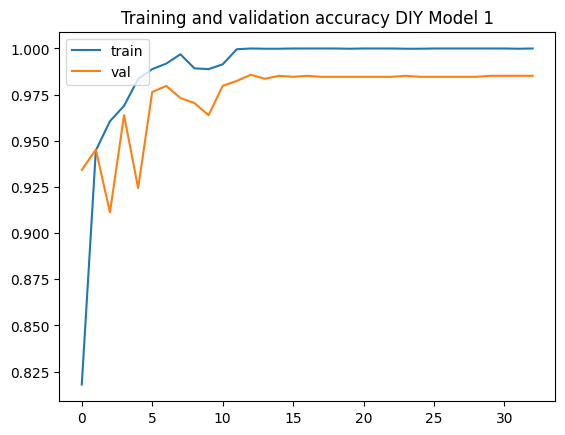

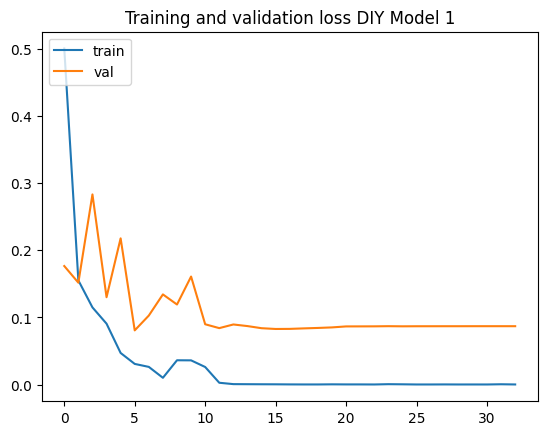

In [12]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DIY_model.history['accuracy' ]
val_acc  = history_DIY_model.history['val_accuracy' ]
loss     = history_DIY_model.history['loss' ]
val_loss = history_DIY_model.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DIY Model 1')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DIY Model 1')
plt.legend(['train', 'val'], loc='upper left')

## DIY Model 2

In [13]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Grape_DIY_model2_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [14]:
# Define DIY Model
DIY_model_2 = tf.keras.models.Sequential([
    # Convolutional Layers with 32 filters
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),
    # Convolutional Layers with 64 filters
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Convolutional Layers with 128 filters
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 1024 neuron hidden layer
    tf.keras.layers.Dense(1024, activation='relu'),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
DIY_model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DIY_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 128)     

In [15]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DIY_model_2 = DIY_model_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
366/367 [============================>.] - ETA: 0s - loss: 0.4561 - accuracy: 0.8286
Epoch 1: val_accuracy improved from -inf to 0.94795, saving model to Grape_DIY_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Grape_DIY_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DIY_model2_Based_Non_Augmented\assets


367/367 [==============================] - 21s 56ms/step - loss: 0.4558 - accuracy: 0.8286 - val_loss: 0.1689 - val_accuracy: 0.9479 - lr: 0.0010
Epoch 2/100
367/367 [==============================] - ETA: 0s - loss: 0.1464 - accuracy: 0.9520
Epoch 2: val_accuracy improved from 0.94795 to 0.97041, saving model to Grape_DIY_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Grape_DIY_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DIY_model2_Based_Non_Augmented\assets


367/367 [==============================] - 20s 55ms/step - loss: 0.1464 - accuracy: 0.9520 - val_loss: 0.0978 - val_accuracy: 0.9704 - lr: 0.0010
Epoch 3/100
367/367 [==============================] - ETA: 0s - loss: 0.1077 - accuracy: 0.9680
Epoch 3: val_accuracy did not improve from 0.97041
367/367 [==============================] - 17s 46ms/step - loss: 0.1077 - accuracy: 0.9680 - val_loss: 0.1209 - val_accuracy: 0.9562 - lr: 0.0010
Epoch 4/100
367/367 [==============================] - ETA: 0s - loss: 0.0581 - accuracy: 0.9800
Epoch 4: val_accuracy did not improve from 0.97041
367/367 [==============================] - 17s 45ms/step - loss: 0.0581 - accuracy: 0.9800 - val_loss: 0.1154 - val_accuracy: 0.9551 - lr: 0.0010
Epoch 5/100
366/367 [============================>.] - ETA: 0s - loss: 0.0687 - accuracy: 0.9806
Epoch 5: val_accuracy did not improve from 0.97041
367/367 [==============================] - 17s 46ms/step - loss: 0.0686 - accuracy: 0.9806 - val_loss: 0.1436 - val_ac

INFO:tensorflow:Assets written to: Grape_DIY_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DIY_model2_Based_Non_Augmented\assets



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
367/367 [==============================] - 23s 64ms/step - loss: 0.0155 - accuracy: 0.9945 - val_loss: 0.1232 - val_accuracy: 0.9797 - lr: 0.0010
Epoch 8/100
366/367 [============================>.] - ETA: 0s - loss: 8.6963e-04 - accuracy: 0.9999
Epoch 8: val_accuracy improved from 0.97973 to 0.98027, saving model to Grape_DIY_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Grape_DIY_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DIY_model2_Based_Non_Augmented\assets


367/367 [==============================] - 24s 65ms/step - loss: 8.6751e-04 - accuracy: 0.9999 - val_loss: 0.1219 - val_accuracy: 0.9803 - lr: 1.0000e-04
Epoch 9/100
367/367 [==============================] - ETA: 0s - loss: 2.5979e-04 - accuracy: 1.0000
Epoch 9: val_accuracy improved from 0.98027 to 0.98082, saving model to Grape_DIY_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Grape_DIY_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DIY_model2_Based_Non_Augmented\assets


367/367 [==============================] - 25s 69ms/step - loss: 2.5979e-04 - accuracy: 1.0000 - val_loss: 0.1264 - val_accuracy: 0.9808 - lr: 1.0000e-04
Epoch 10/100
366/367 [============================>.] - ETA: 0s - loss: 1.8249e-04 - accuracy: 1.0000
Epoch 10: val_accuracy did not improve from 0.98082
367/367 [==============================] - 17s 46ms/step - loss: 1.8199e-04 - accuracy: 1.0000 - val_loss: 0.1281 - val_accuracy: 0.9803 - lr: 1.0000e-04
Epoch 11/100
367/367 [==============================] - ETA: 0s - loss: 1.2634e-04 - accuracy: 1.0000
Epoch 11: val_accuracy improved from 0.98082 to 0.98192, saving model to Grape_DIY_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Grape_DIY_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Grape_DIY_model2_Based_Non_Augmented\assets


367/367 [==============================] - 25s 69ms/step - loss: 1.2634e-04 - accuracy: 1.0000 - val_loss: 0.1324 - val_accuracy: 0.9819 - lr: 1.0000e-04
Epoch 12/100
367/367 [==============================] - ETA: 0s - loss: 7.7251e-05 - accuracy: 1.0000
Epoch 12: val_accuracy did not improve from 0.98192

Epoch 12: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
367/367 [==============================] - 17s 46ms/step - loss: 7.7251e-05 - accuracy: 1.0000 - val_loss: 0.1343 - val_accuracy: 0.9814 - lr: 1.0000e-04
Epoch 13/100
366/367 [============================>.] - ETA: 0s - loss: 7.5702e-05 - accuracy: 1.0000
Epoch 13: val_accuracy did not improve from 0.98192
367/367 [==============================] - 17s 45ms/step - loss: 7.5500e-05 - accuracy: 1.0000 - val_loss: 0.1347 - val_accuracy: 0.9814 - lr: 1.0000e-05
Epoch 14/100
367/367 [==============================] - ETA: 0s - loss: 8.5326e-05 - accuracy: 1.0000
Epoch 14: val_accuracy did not improve from 0.981

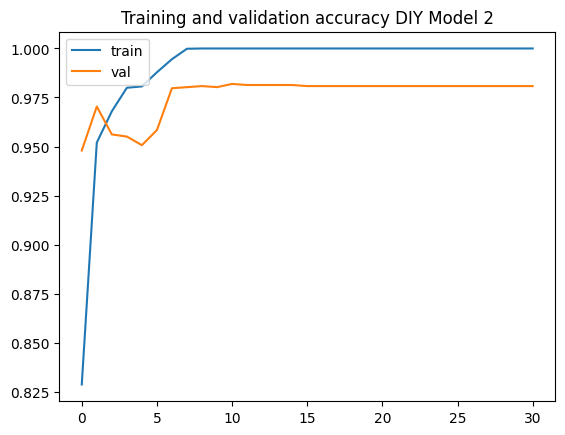

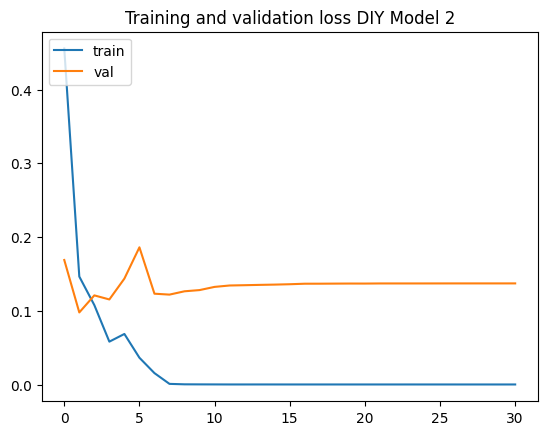

In [16]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DIY_model_2.history['accuracy' ]
val_acc  = history_DIY_model_2.history['val_accuracy' ]
loss     = history_DIY_model_2.history['loss' ]
val_loss = history_DIY_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DIY Model 2')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DIY Model 2')
plt.legend(['train', 'val'], loc='upper left')